# Server-side Feature Inference Attacks against Split Learning: `credit-card`

## Import packages and dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sl_with_attack
from sl_with_attack import *
from datasets import *

xpriv, xpub = load_credit_card(normalization="feature")

## Setting up hyperparameters and util functions

In [2]:
batch_size = 64
id_setup = 4
hparams = {
    'WGAN' : True,
    # 'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.000001,
}

iterations = 10000
log_frequency = 400

def plot_log(ax, x, y, label=None, color='blue'):
    ax.plot(x, y, color=color)
    ax.grid()
    if label is not None:
        ax.set(title=label)

## Model architectures

In [3]:
def f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(32, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def g(input_shape, class_num):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(128, activation="relu")(xin)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

def encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "elu"
    x = tf.keras.layers.Dense(32, activation=act)(xin)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    return tf.keras.Model(xin, x)

def decoder(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = "elu"
    x = tf.keras.layers.Dense(64, activation=act)(xin)
    # x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(23)(x)
    # x = x * x
    # x = tf.abs(x)
    # x = x * (max_values - min_values) + min_values
    return tf.keras.Model(xin, x)

def discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256)(xin)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

In [4]:
models = (f, g, encoder, decoder, discriminator)

## Passive Attack

In [5]:
passive = sl_with_attack(models, xpriv, xpub, id_setup-1, batch_size, hparams, 2, server_attack="passive", sorted=False)
log_passive = passive(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
[log--03%-0000399] reconstruction validation: 0.0857
Original task: train loss: 0.6882 train accuracy: 0.6136
[log--07%-0000799] reconstruction validation: 0.0514
Original task: train loss: 0.6830 train accuracy: 0.7278
[log--11%-0001199] reconstruction validation: 0.0362
Original task: train loss: 0.6780 train accuracy: 0.7730
[log--15%-0001599] reconstruction validation: 0.0310
Original task: train loss: 0.6727 train accuracy: 0.7804
[log--19%-0001999] reconstruction validation: 0.0276
Original task: train loss: 0.6677 train accuracy: 0.7811
[log--23%-0002399] reconstruction validation: 0.0194
Original task: train loss: 0.6625 train accuracy: 0.7818
[log--27%-0002799] reconstruction validation: 0.0203
Original task: train loss: 0.6577 train accuracy: 0.7803
[log--31%-0003199] reconstruction validation: 0.0209
Original task: train loss: 0.6530 train accuracy: 0.7783
[log--35%-0003599] reconstruction validation: 0.0211
Original task: train loss: 0.6476 train accuracy: 0.7820

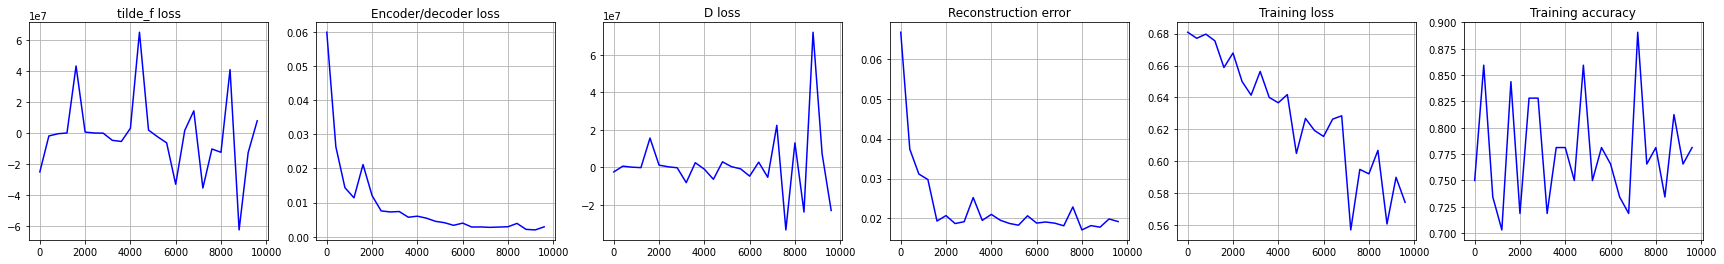

In [6]:
n = 6
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_passive)) * log_frequency

plot_log(ax[0], x, log_passive[:, 0],  label='tilde_f loss')
plot_log(ax[1], x, log_passive[:, 1],  label='Encoder/decoder loss')
plot_log(ax[2], x, log_passive[:, 2],  label='D loss')
plot_log(ax[3], x, log_passive[:, 3],  label='Reconstruction error')
plot_log(ax[4], x, log_passive[:, 4], label='Training loss')
plot_log(ax[5], x, log_passive[:, 5],  label='Training accuracy')

In [1]:
X = np.concatenate([x[0].numpy()[None] for x in xpriv.take(5)])
original = X
constructed = passive.attack(X)[0]
for i in range(5):
    print("compare:")
    print(original[i])
    print(constructed[i])

NameError: name 'np' is not defined